In [1]:
import os, sys
import numpy as np

In [2]:
from skimage import io
import pandas as pd
import json

In [3]:
import anndata
import scanpy as sc
import squidpy as sq

In [4]:
data_root = r"E:\LungIMCData\HumanSampling35\LungROIProcessing\Steinbock"

In [5]:
rois_h5ad_path = os.path.join(data_root, "rois.h5ad")
rois_adata = sc.read_h5ad(rois_h5ad_path)

In [6]:
# add spatial coordinates
spatial_coords = np.transpose(np.asarray([rois_adata.obs["centroid-1"].tolist(), rois_adata.obs["centroid-0"].tolist()]))
rois_adata.obsm["spatial"] = spatial_coords

In [7]:
# obtain roi list based on h5ad file
roi_list = []
for cur_roi in rois_adata.obs["image"]:
    cur_roi_name = cur_roi[:-5]
    if cur_roi_name not in roi_list:
        roi_list.append(cur_roi_name)

In [8]:
# load cell phenotype & library ids information
cell_phenotype_dict = None
cell_phenotype_path = os.path.join(data_root, "cell_phenotypes.json")
with open(cell_phenotype_path) as fp:
    cell_phenotype_dict = json.load(fp)
cell_ids = [ele for ele in cell_phenotype_dict.keys()]
cell_phenotypes = []
library_ids = []
cell_nums = []
# collect roi list
roi_lst = []
for cell_id in cell_ids:
    roi_name = cell_id[:cell_id.rfind("_")]
    if roi_name not in roi_lst:
        roi_lst.append(roi_name)
# collect roi cell numbers
roi_cell_dict = {}
for cell_id in cell_ids:
    roi_name = cell_id[:cell_id.rfind("_")]
    if roi_name not in roi_cell_dict:
        roi_cell_dict[roi_name] = 1
    else:   
        roi_cell_dict[roi_name] += 1
# collect cell_phenotypes
for roi_name in roi_lst:
    cell_num = roi_cell_dict[roi_name]
    cell_phenotypes.extend([cell_phenotype_dict[roi_name + "_" + str(num)] for num in range(1, cell_num + 1)])
    library_ids.extend([roi_name, ] * cell_num)
    cell_nums.extend([ele for ele in range(1, cell_num + 1)])
# convert to Categorical
rois_cell_phenotypes = pd.Categorical(cell_phenotypes) 
rois_library_ids = pd.Categorical(library_ids) 
rois_adata.obs["cell_type"] = rois_cell_phenotypes
rois_adata.obs["library_id"] = rois_library_ids
rois_adata.obs["cell_id"] = cell_nums

In [10]:
sq.gr.spatial_neighbors(rois_adata, spatial_key="spatial", library_key="library_id", coord_type="generic", radius=16.0)

In [13]:
# test_roi_name = "H14-0290-12-ROI024"
# sq.pl.spatial_scatter(rois_adata, shape=None, color="cell_type", library_id=test_roi_name, library_key="library_id", connectivity_key="spatial_connectivities", figsize=(12, 12), size=10)

In [15]:
sq.gr.nhood_enrichment(rois_adata, cluster_key="cell_type")

C:\Users\PChen6\.conda\envs\GraphML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.36/s]


In [17]:
rois_adata.uns["cell_type_nhood_enrichment"]

{'zscore': array([[ 3.83850967e+02, -2.51090663e+00,  4.04414032e-01,
          7.40017690e+00,  1.31762500e+01, -6.34272336e+01,
         -7.86990174e+00,  2.24038018e+00,  4.72291349e+01,
          5.09231369e+00,  2.05733725e+01, -9.59213453e+00,
         -5.23238563e+01, -3.42149395e+00],
        [-2.51090663e+00,  6.72732467e+01,  2.19544503e+01,
         -3.54917319e-01,  6.61178023e+00, -2.18867346e+01,
          1.55135704e+00,  1.72718540e+00, -5.77171329e+00,
          1.93247016e+01, -1.82752570e+00, -5.74211386e+00,
         -6.61496281e+00,  8.47750184e+00],
        [ 4.04414032e-01,  2.19544503e+01,  8.86504246e+01,
         -3.89344440e+00,  5.43887486e+00, -2.56243471e+01,
         -6.85654746e+00, -4.67196173e+00,  5.23849829e+00,
          2.02387559e+01,  2.14786322e+01, -8.26929089e+00,
         -1.18117699e+01,  8.30278919e+00],
        [ 7.40017690e+00, -3.54917319e-01, -3.89344440e+00,
          2.62035483e+02, -2.39231164e+01, -4.46566471e+01,
         -2.431437

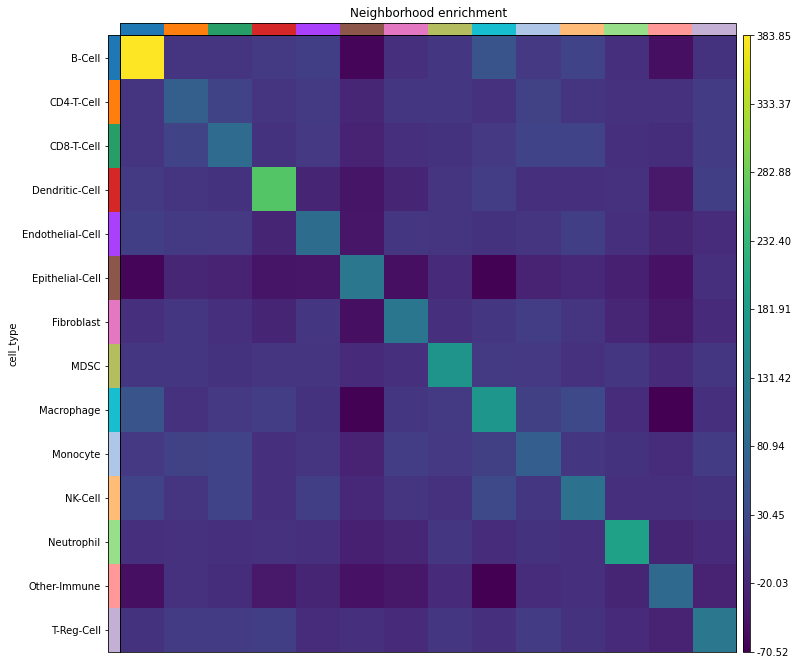

In [19]:
sq.pl.nhood_enrichment(rois_adata, cluster_key="cell_type")